In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from matplotlib import pyplot as plt

torch.manual_seed(1337)

In [2]:
word_to_ix = {'hello': 0, 'world': 1}
embeds = nn.Embedding(2, 5) # 2 embedding vectors of 5d
lookup_tensor = torch.tensor([word_to_ix['hello']], dtype=torch.long)
hello_embed = embeds(lookup_tensor)

In [3]:
hello_embed # This was a randomly initialized value

tensor([[-2.0260, -2.0655, -1.2054, -0.9122, -1.2502]], grad_fn=<EmbeddingBackward>)

### N-Gram Language Model
$p(w_i | w _{i-1}, w _{i-2})$ --`bigram language model`

In [4]:
CONTEXT_SIZE = 2
EMBEDDING_DIM = 10

# We will use Shakespeare Sonnet 2
test_sentence = """When forty winters shall besiege thy brow,
And dig deep trenches in thy beauty's field,
Thy youth's proud livery so gazed on now,
Will be a totter'd weed of small worth held:
Then being asked, where all thy beauty lies,
Where all the treasure of thy lusty days;
To say, within thine own deep sunken eyes,
Were an all-eating shame, and thriftless praise.
How much more praise deserv'd thy beauty's use,
If thou couldst answer 'This fair child of mine
Shall sum my count, and make my old excuse,'
Proving his beauty by succession thine!
This were to be new made when thou art old,
And see thy blood warm when thou feel'st it cold.""".split()

In [5]:
# we should tokenize the input, but we will ignore that for now
# build a list of tuples.  Each tuple is ([ word_i-2, word_i-1 ], target word)

trigrams = [([test_sentence[i-2], test_sentence[i-1]], 
             test_sentence[i]) for i in range(2, len(test_sentence))]

In [6]:
print(trigrams[:1])

[(['When', 'forty'], 'winters')]


In [7]:
vocab = set(test_sentence)
word_to_ix = {word: i for i, word in enumerate(vocab)}

In [8]:
class NGramLanguageModeler(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGramLanguageModeler, self).__init__()
        
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        # concatenate the embeddings of w_2 and w_1
        self.linear1 = nn.Linear(context_size * embedding_dim, 128) 
        self.linear2 = nn.Linear(128, vocab_size) # final softmax layer
        
    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1)) # reshape it from [2, emb-dim] to [1, 2*emb-dim]
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim = 1) # 0th dim is batch-size
        return log_probs
        

In [9]:
losses = []
loss_function = nn.NLLLoss()

model = NGramLanguageModeler(vocab_size = len(vocab), 
                             embedding_dim = EMBEDDING_DIM,
                             context_size = CONTEXT_SIZE
                            )

optimizer = optim.SGD(model.parameters(), lr=0.001)

In [10]:
for epoch in range(10):
    total_loss = 0
    
    for context, target in trigrams:
        
        # convert words to idx which are torch tensors
        context_ids = torch.tensor([word_to_ix[w] for w in context], 
                                   dtype=torch.long)
        
        # reset gradients to zero
        model.zero_grad()
        
        log_probs = model.forward(inputs=context_ids)
        
        # loss function 
        loss = loss_function(log_probs, torch.tensor([word_to_ix[target]], dtype=torch.long))
        
        # backprop and weight update
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() # sum the loss from individual samples to get epoch level loss
        
    losses.append(total_loss)
    
print(losses)
                                       

[522.3382515907288, 519.8384222984314, 517.3549876213074, 514.887852191925, 512.4363434314728, 509.9990186691284, 507.5758202075958, 505.16576862335205, 502.7680060863495, 500.381174325943]


Text(0,0.5,'Loss')

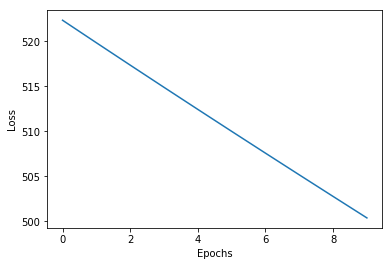

In [11]:
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')

### CBOW
Given the previous and next word (surrounding words), predict the current word

In [12]:
CONTEXT_SIZE = 2  # 2 words to the left, 2 to the right
raw_text = """We are about to study the idea of a computational process.
Computational processes are abstract beings that inhabit computers.
As they evolve, processes manipulate other abstract things called data.
The evolution of a process is directed by a pattern of rules
called a program. People create programs to direct processes. In effect,
we conjure the spirits of the computer with our spells.""".split()

# By deriving a set from `raw_text`, we deduplicate the array
vocab = set(raw_text)
vocab_size = len(vocab)

word_to_ix = {word: i for i, word in enumerate(vocab)}
data = []
for i in range(2, len(raw_text) - 2):
    context = [raw_text[i - 2], raw_text[i - 1],
               raw_text[i + 1], raw_text[i + 2]]
    target = raw_text[i]
    data.append((context, target))
print(data[:5])

[(['We', 'are', 'to', 'study'], 'about'), (['are', 'about', 'study', 'the'], 'to'), (['about', 'to', 'the', 'idea'], 'study'), (['to', 'study', 'idea', 'of'], 'the'), (['study', 'the', 'of', 'a'], 'idea')]


In [13]:
class CBOW(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(CBOW, self).__init__()
        
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        # concatenate the embeddings of w_2 and w_1
        self.linear1 = nn.Linear(2 * context_size * embedding_dim, 128) 
        self.linear2 = nn.Linear(128, vocab_size) # final softmax layer

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1)) 
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim = 1) # 0th dim is batch-size
        return log_probs

In [14]:
losses = []
loss_function = nn.NLLLoss()

model = CBOW(vocab_size = vocab_size, 
             embedding_dim = EMBEDDING_DIM,
             context_size = CONTEXT_SIZE
            )

optimizer = optim.SGD(model.parameters(), lr=0.001)

In [15]:
for epoch in range(10):
    total_loss = 0
    
    for context, target in data:
        
        # convert words to idx which are torch tensors
        context_ids = torch.tensor([word_to_ix[w] for w in context], 
                                   dtype=torch.long)
        
        # reset gradients to zero
        model.zero_grad()
        
        log_probs = model.forward(inputs=context_ids)
        
        # loss function 
        loss = loss_function(log_probs, torch.tensor([word_to_ix[target]], dtype=torch.long))
        
        # backprop and weight update
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() # sum the loss from individual samples to get epoch level loss
        
    losses.append(total_loss)
    
print(losses)

[228.44770002365112, 226.82502269744873, 225.2153458595276, 223.61829257011414, 222.03282570838928, 220.45676517486572, 218.88988304138184, 217.33286833763123, 215.78503894805908, 214.24438190460205]
